In [1]:
#%tensorflow_version 1.x
import numpy as np   #Package for scientific computing and dealing with arrays
import pandas as pd  #Package providing fast, flexible and expressive data structures
import re            #re stands for RegularExpression providing full support for Perl-like Regular Expressions in Python
from bs4 import BeautifulSoup   #Package for pulling data out of HTML and XML files
from tensorflow.keras.preprocessing.text import Tokenizer  #For tokenizing the input sequences
from keras.preprocessing.sequence import pad_sequences  #For Padding the seqences to same length
from nltk.corpus import stopwords   #For removing filler words
from tensorflow.keras.layers import Input, LSTM, Attention, Embedding, Dense, Concatenate, TimeDistributed   #Layers required to implement the model
from tensorflow.keras.models import Model  #Helps in grouping the layers into an object with training and inference features
from tensorflow.keras.callbacks import EarlyStopping  #Allows training the model on large no. of training epochs & stop once the performance stops improving on validation dataset
import warnings  #shows warning message that may arise 

pd.set_option("display.max_colwidth", 200) #Setting the data sructure display length
warnings.filterwarnings("ignore") 

Using TensorFlow backend.


In [2]:
def readingDataACL(path: str):
    """
    Read the ACL data
    :param path: File path to read the data from
    :return: titles, abstracts NOTE: corresponds to y, x for training
    """
    abstractTitles = open(path, "r").read()
    papers = [paper.split("\n") for paper in abstractTitles.split("\n\n")]
    return zip(*papers)

In [3]:
#titles, abstracts = readingDataACL("dataAnalysis/data/acl_titles_and_abstracts.txt")
arxiv = pd.read_csv("dataAnalysis/data/ML-Arxiv-Papers.csv")
titles, abstracts = arxiv['title'],arxiv['abstract']

In [4]:
DATASET_COLUMNS = ["Summary", "Text"] #titles, abstracts
reviewsData = pd.DataFrame({"Summary": titles, "Text": abstracts})

In [5]:
reviewsData.info() #Getting more info on datatypes and shape of Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117592 entries, 0 to 117591
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Summary  117592 non-null  object
 1   Text     117592 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [6]:
#Preprocessing

#This the dictionary used for expanding contractions
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [7]:
#Text Cleaning
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 
def text_cleaner(text,num):
    newString = text.lower()  #converts all uppercase characters in the string into lowercase characters and returns it
    newString = BeautifulSoup(newString, "lxml").text #parses the string into an lxml.html 
    newString = re.sub(r'\([^)]*\)', '', newString) #used to replace a string that matches a regular expression instead of perfect match
    newString = re.sub('"','', newString)           
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) #for expanding contractions using the contraction_mapping dictionary    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    if(num==0): 
      tokens = [w for w in newString.split() if not w in stop_words]  #converting the strings into tokens
    else :
      tokens = newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                  #removing short words
            long_words.append(i)   
    return (" ".join(long_words)).strip()

#Calling the function
cleaned_text = []
for t in reviewsData['Text']:
    cleaned_text.append(text_cleaner(t,0))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\janni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Skipping text cleaning for now - probably not much impact for abstracts
cleaned_text = reviewsData['Text']

In [9]:
reviewsData['Text'][:10] #Looking at the 'Text' column of the dataset

0      The problem of statistical learning is to construct a predictor of a random\nvariable $Y$ as a function of a related random variable $X$ on the basis of an\ni.i.d. training sample from the joint...
1      In a sensor network, in practice, the communication among sensors is subject\nto:(1) errors or failures at random times; (3) costs; and(2) constraints since\nsensors and networks operate under s...
2      The on-line shortest path problem is considered under various models of\npartial monitoring. Given a weighted directed acyclic graph whose edge weights\ncan change in an arbitrary (adversarial) ...
3      Ordinal regression is an important type of learning, which has properties of\nboth classification and regression. Here we describe a simple and effective\napproach to adapt a traditional neural ...
4      This paper uncovers and explores the close relationship between Monte Carlo\nOptimization of a parametrized integral (MCO), Parametric machine-Learning\n(PL), and `blackbox'

In [10]:
cleaned_text[:10] #Looking at the Text after removing stop words, special characters , punctuations etc.

0      The problem of statistical learning is to construct a predictor of a random\nvariable $Y$ as a function of a related random variable $X$ on the basis of an\ni.i.d. training sample from the joint...
1      In a sensor network, in practice, the communication among sensors is subject\nto:(1) errors or failures at random times; (3) costs; and(2) constraints since\nsensors and networks operate under s...
2      The on-line shortest path problem is considered under various models of\npartial monitoring. Given a weighted directed acyclic graph whose edge weights\ncan change in an arbitrary (adversarial) ...
3      Ordinal regression is an important type of learning, which has properties of\nboth classification and regression. Here we describe a simple and effective\napproach to adapt a traditional neural ...
4      This paper uncovers and explores the close relationship between Monte Carlo\nOptimization of a parametrized integral (MCO), Parametric machine-Learning\n(PL), and `blackbox'

In [11]:
#Summary Cleaning 
cleaned_summary = []    #Using the text_cleaner function for cleaning summary too
for t in reviewsData['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [12]:
reviewsData['Summary'][:10]

0                                                      Learning from compressed observations
1            Sensor Networks with Random Links: Topology Design for Distributed\n  Consensus
2                                 The on-line shortest path problem under partial monitoring
3                                            A neural network approach to ordinal regression
4                                           Parametric Learning and Monte Carlo Optimization
5                                                Preconditioned Temporal Difference Learning
6                                  A Note on the Inapproximability of Correlation Clustering
7            Joint universal lossy coding and identification of stationary mixing\n  sources
8                                     Supervised Feature Selection via Dependence Estimation
9    Equivalence of LP Relaxation and Max-Product for Weighted Matching in\n  General Graphs
Name: Summary, dtype: object

In [13]:
cleaned_summary[:10]

['learning from compressed observations',
 'sensor networks with random links topology design for distributed consensus',
 'the on line shortest path problem under partial monitoring',
 'neural network approach to ordinal regression',
 'parametric learning and monte carlo optimization',
 'preconditioned temporal difference learning',
 'note on the inapproximability of correlation clustering',
 'joint universal lossy coding and identification of stationary mixing sources',
 'supervised feature selection via dependence estimation',
 'equivalence of lp relaxation and max product for weighted matching in general graphs']

In [14]:
reviewsData['Cleaned_Text'] = cleaned_text  #Adding cleaned text to the dataset
reviewsData['Cleaned_Summary'] = cleaned_summary  #Adding cleaned summary to the dataset
#Dropping Empty Rows
reviewsData['Cleaned_Summary'].replace('', np.nan, inplace=True)
#Dropping rows with Missing values
reviewsData.dropna(axis=0,inplace=True)

In [15]:
#Before Cleaning
print("Before Preprocessing:\n")
for i in range(5):
    print("Review:",reviewsData['Text'][i])
    print("Summary:",reviewsData['Summary'][i])
    print("\n")

Before Preprocessing:

Review:   The problem of statistical learning is to construct a predictor of a random
variable $Y$ as a function of a related random variable $X$ on the basis of an
i.i.d. training sample from the joint distribution of $(X,Y)$. Allowable
predictors are drawn from some specified class, and the goal is to approach
asymptotically the performance (expected loss) of the best predictor in the
class. We consider the setting in which one has perfect observation of the
$X$-part of the sample, while the $Y$-part has to be communicated at some
finite bit rate. The encoding of the $Y$-values is allowed to depend on the
$X$-values. Under suitable regularity conditions on the admissible predictors,
the underlying family of probability distributions and the loss function, we
give an information-theoretic characterization of achievable predictor
performance in terms of conditional distortion-rate functions. The ideas are
illustrated on the example of nonparametric regression in 

In [16]:
#Printing the Cleaned text and summary which will work as input to the model 
print("After Preprocessing:\n")
for i in range(5):
    print("Review:",reviewsData['Cleaned_Text'][i])
    print("Summary:",reviewsData['Cleaned_Summary'][i])
    print("\n")

After Preprocessing:

Review:   The problem of statistical learning is to construct a predictor of a random
variable $Y$ as a function of a related random variable $X$ on the basis of an
i.i.d. training sample from the joint distribution of $(X,Y)$. Allowable
predictors are drawn from some specified class, and the goal is to approach
asymptotically the performance (expected loss) of the best predictor in the
class. We consider the setting in which one has perfect observation of the
$X$-part of the sample, while the $Y$-part has to be communicated at some
finite bit rate. The encoding of the $Y$-values is allowed to depend on the
$X$-values. Under suitable regularity conditions on the admissible predictors,
the underlying family of probability distributions and the loss function, we
give an information-theoretic characterization of achievable predictor
performance in terms of conditional distortion-rate functions. The ideas are
illustrated on the example of nonparametric regression in G

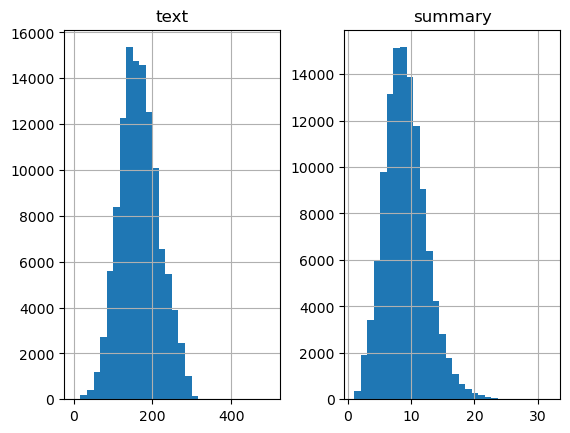

In [17]:
#Data Visualization
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

#Populating the lists with sentence lengths
for i in reviewsData['Cleaned_Text']:
      text_word_count.append(len(i.split()))

for i in reviewsData['Cleaned_Summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [18]:
#Function for getting the Maximum Review length  
count=0 
for i in reviewsData['Cleaned_Text']:
    if(len(i.split())<=35):
        count=count+1
print(count/len(reviewsData['Cleaned_Text']))

0.0018708755697666509


In [19]:
#Function for getting the Maximum Summary length
count=0
for i in reviewsData['Cleaned_Summary']:
    if(len(i.split())<=8):
        count=count+1
print(count/len(reviewsData['Cleaned_Summary']))

0.4227158310089122


In [20]:
#From the above data we got an idea about maximum lengths of review and summary
max_text_len = 300 # 35
max_summary_len = 20 # 8

In [21]:
#Adding START and END tags to summary for better decoding
cleaned_text =np.array(reviewsData['Cleaned_Text'])
cleaned_summary=np.array(reviewsData['Cleaned_Summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [22]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [23]:
#Splitting the Dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.2,random_state=0,shuffle=True)

In [24]:
#Preparing Tokenizer

#Text Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#preparing a tokenizer for reviews on training data
X_tokenizer = Tokenizer() 
X_tokenizer.fit_on_texts(list(X_train))

In [25]:
#Rarewords and their coverage in review
thresh = 4  #If a word whose count is less than threshold i.e 4, then it's considered as rare word 

cnt = 0      #denotes no. of rare words whose count falls below threshold
tot_cnt = 0  #denotes size of unique words in the text
freq = 0
tot_freq = 0

for key,value in X_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 60.8361987342403
Total Coverage of rare words: 0.5804073404243705


In [26]:
#Defining the Tokenizer with top most common words for reviews

#Preparing a Tokenizer for reviews on training data
X_tokenizer = Tokenizer(num_words=tot_cnt-cnt)   #provides top most common words
X_tokenizer.fit_on_texts(list(X_train))

#Converting text sequences into integer sequences
X_train_seq    =   X_tokenizer.texts_to_sequences(X_train) 
X_test_seq   =   X_tokenizer.texts_to_sequences(X_test)

#Padding zero upto maximum length
X_train    =   pad_sequences(X_train_seq,  maxlen = max_text_len, padding = 'post')
X_test   =   pad_sequences(X_test_seq, maxlen = max_text_len, padding = 'post')

#Size of vocabulary (+1 for padding token)
X_voc   =  X_tokenizer.num_words + 1

In [27]:
X_voc 

39296

In [28]:
#Summary Tokenizer

#Preparing a Tokenizer for summaries on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

In [29]:
#Rarewords and their coverage in summary

thresh = 6  ##If a word whose count is less than threshold i.e 6, then it's considered as rare word 

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt+1
    tot_freq = tot_freq+value
    if(value<thresh):
        cnt = cnt+1
        freq = freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 77.21325120692525
Total Coverage of rare words: 3.458794309161909


In [30]:
#Defining Tokenizer with the most common words in summary

#Preparing a tokenizer for summaries on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)  #provides top most common words
y_tokenizer.fit_on_texts(list(y_train))

#Converting text sequences into integer sequences
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_test_seq   =   y_tokenizer.texts_to_sequences(y_test) 

#Padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [31]:
y_voc

6845

In [32]:
#Checking the length of training data
y_tokenizer.word_counts['sostok'],len(y_train)

(93632, 93632)

In [33]:
#Deleting rows containing START and END tokens
#For Training set
ind=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_train=np.delete(y_train,ind, axis=0)
X_train=np.delete(X_train,ind, axis=0)

In [34]:
#For Validation set
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
X_test=np.delete(X_test,ind, axis=0)

In [35]:
from tensorflow.keras import layers
import tensorflow as tf

class InitialStateLayer(layers.Layer):
    def __init__(self, hidden_size, **kwargs):
        super(InitialStateLayer, self).__init__(**kwargs)
        self.hidden_size = hidden_size
    
    def call(self, inputs):
        # Use TensorFlow's tf.zeros_like for symbolic tensors
        fake_state = tf.zeros_like(inputs)  # Create a tensor of zeros with the same shape as 'inputs'
        fake_state = tf.reduce_sum(fake_state, axis=[1, 2])  # Sum over sequence length and feature dimensions
        fake_state = tf.expand_dims(fake_state, axis=-1)  # Expand dims to make it (batch_size, 1)
        fake_state = tf.tile(fake_state, [1, self.hidden_size])  # Repeat the fake state across the hidden size dimension
        return fake_state

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

# Define the custom energy step function as an RNNCell
class EnergyStep(Layer):
    def __init__(self, **kwargs):
        super(EnergyStep, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Add weights or any required setup here
        super(EnergyStep, self).build(input_shape)
    
    def call(self, inputs, states):
        decoder_out_seq, fake_state_e = inputs
        # Define your custom energy computation logic
        # Example: simple linear transformation as energy computation
        energy = tf.reduce_sum(decoder_out_seq * fake_state_e, axis=-1)
        return energy, [energy]  # Return energy and updated state (energy as the new state)

# Define the custom context step function as an RNNCell
class ContextStep(Layer):
    def __init__(self, **kwargs):
        super(ContextStep, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Add weights or any required setup here
        super(ContextStep, self).build(input_shape)
    
    def call(self, inputs, states):
        e_outputs, fake_state_c = inputs
        # Define your custom context computation logic
        # Example: simple linear transformation for context computation
        context = tf.reduce_sum(e_outputs * fake_state_c, axis=-1)
        return context, [context]  # Return context and updated state (context as the new state)


In [37]:
# NEW: Specify tensorflow version #
tf2 = False



#Model Building

#Adding Custom Attention layer 

import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
from tensorflow.keras.layers import Layer, RNN


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state


        if tf2:
        # NEW implementation #
            # For `fake_state_c`, use axis=-1 (i.e., reduce over the feature dimension)
            initial_state_layer_c = InitialStateLayer(hidden_size=encoder_out_seq.shape[-1])
            fake_state_c = initial_state_layer_c(encoder_out_seq)
            
            # For `fake_state_e`, use axis=1 (i.e., reduce over the sequence length)
            initial_state_layer_e = InitialStateLayer(hidden_size=encoder_out_seq.shape[1])
            fake_state_e = initial_state_layer_e(encoder_out_seq)
    
    
            energy_cell = EnergyStep()
            context_cell = ContextStep()
    
    
            # Use RNN with the custom energy cell to compute e_outputs
            rnn_energy = RNN(energy_cell, return_state=True, return_sequences=True)
            last_out, e_outputs, _ = rnn_energy([decoder_out_seq, fake_state_e])
            
            # Use RNN with the custom context cell to compute c_outputs
            rnn_context = RNN(context_cell, return_state=True, return_sequences=True)
            last_out, c_outputs, _ = rnn_context([e_outputs, fake_state_c])


        else:
        # OLD implementation #
            fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
            fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim
            
            
            """ Computing energy outputs """
            #e_outputs => (batch_size, de_seq_len, en_seq_len)
            last_out, e_outputs, _ = K.rnn(
                energy_step, decoder_out_seq, [fake_state_e],
            )
            
            """ Computing context vectors """
            last_out, c_outputs, _ = K.rnn(
                context_step, e_outputs, [fake_state_c],
            )
        
        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [38]:
from keras import backend as K 
K.clear_session()  #Resets all state generated by Keras

latent_dim = 256
embedding_dim = 256

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(X_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3= LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#Setting up the Decoder using 'encoder_states' as initial state
decoder_inputs = Input(shape=(None,))

#Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

#Concating Attention input and Decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

#Defining the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 256)     10059776    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 300, 256), ( 525312      embedding[0][0]                  
_____________________________________________________________________________________________

In [39]:
#Visualize the Model
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [40]:
#Adding Metrics
model.compile(optimizer='rmsprop' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'])

In [41]:
#Adding Callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
#Training the Model
#%tensorflow_version 1.x
history = model.fit([X_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size= 64, validation_data=([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 93616 samples, validate on 23406 samples
Epoch 1/50
 1088/93616 [..............................] - ETA: 3:29:28 - loss: 4.7316 - acc: 0.4478

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_9000\4225422050.py", line 3, in <module>
    history = model.fit([X_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size= 64, validation_data=([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 727, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\tensorflow_core\python\keras\engine\training_arrays.py", line 675, in fit
    steps_name='steps_per_epoch')
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\tensorflow_core\python\keras\engine\training_arr

In [ ]:
#Visualizing Accuracy 
from matplotlib import pyplot
pyplot.plot(history.history['acc'], label='train') 
pyplot.plot(history.history['val_acc'], label='test') 
pyplot.legend() 
pyplot.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\3772741723.py", line 3, in <module>
    pyplot.plot(history.history['acc'], label='train')
NameError: name 'history' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_

In [ ]:
#Visualizing Loss 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\310473503.py", line 2, in <module>
    pyplot.plot(history.history['loss'], label='train')
NameError: name 'history' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_

In [37]:
#Building Dictionary for Source Vocabulary
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=X_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

ERROR! Session/line number was not unique in database. History logging moved to new session 183


In [ ]:
#Inference/Validation Phase
#Encoding the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

#Decoder setup
#These tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

#Getting the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 

#Setting the initial states to the states from the previous time step for better prediction
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#Attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

#Adding Dense softmax layer to generate proability distribution over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

#Final Decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\3923141111.py", line 3, in <module>
    encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
NameError: name 'encoder_outputs' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
  

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\3923141111.py", line 3, in <module>
    encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
NameError: name 'encoder_outputs' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_a

In [38]:
#Function defining the implementation of inference process
def decode_sequence(input_seq):
    #Encoding the input as state vectors
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1,1))
    
    #Populating the first word of target sequence with the start word
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        #Sampling a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        #Exit condition: either hit max length or find stop word
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        #Updating the target sequence (of length 1)
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        #Updating internal states
        e_h, e_c = h, c

    return decoded_sentence

ERROR! Session/line number was not unique in database. History logging moved to new session 184


In [39]:
#Functions to convert an integer sequence to a word sequence for summary as well as reviews 
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
#Summaries generated by the model

for i in range(0,20):
    print("Review:",seq2text(X_train[i]))
    print("Original summary:",seq2summary(y_train[i]))
    print("Predicted summary:",decode_sequence(X_train[i].reshape(1,max_text_len)))
    print("\n")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\3190860045.py", line 4, in <module>
    print("Review:",seq2text(X_train[i]))
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\1577029050.py", line 13, in seq2text
    newString=newString+reverse_source_word_index[i]+' '
KeyError: ' '

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\sit

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\3190860045.py", line 4, in <module>
    print("Review:",seq2text(X_train[i]))
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\1577029050.py", line 13, in seq2text
    newString=newString+reverse_source_word_index[i]+' '
KeyError: ' '

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\sit

In [ ]:
#BLEU Score of Training set
#n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for i in range(0,1000):
  reference = seq2summary(y_train[i])
  candidate = decode_sequence(X_train[i].reshape(1, max_text_len))

print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\2865545400.py", line 6, in <module>
    candidate = decode_sequence(X_train[i].reshape(1, max_text_len))
AttributeError: 'str' object has no attribute 'reshape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fi

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\2865545400.py", line 6, in <module>
    candidate = decode_sequence(X_train[i].reshape(1, max_text_len))
AttributeError: 'str' object has no attribute 'reshape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
   

In [ ]:
#4-gram cumulative BLEU
from nltk.translate.bleu_score import sentence_bleu
for i in range(0,1000):
  reference = seq2summary(y_train[i])
  candidate = decode_sequence(X_train[i].reshape(1, max_text_len))

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(score)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\450826727.py", line 5, in <module>
    candidate = decode_sequence(X_train[i].reshape(1, max_text_len))
AttributeError: 'str' object has no attribute 'reshape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fix

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\450826727.py", line 5, in <module>
    candidate = decode_sequence(X_train[i].reshape(1, max_text_len))
AttributeError: 'str' object has no attribute 'reshape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
    

In [ ]:
#cumulative BLEU scores
from nltk.translate.bleu_score import sentence_bleu
for i in range(0,1000):
  reference = seq2summary(y_train[i])
  candidate = decode_sequence(X_train[i].reshape(1, max_text_len))

print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\3248707841.py", line 5, in <module>
    candidate = decode_sequence(X_train[i].reshape(1, max_text_len))
AttributeError: 'str' object has no attribute 'reshape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fi

In [ ]:
#BLEU Score of Test/Validation set
#n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for i in range(0,1000):
  reference = seq2summary(y_test[i])
  candidate = decode_sequence(X_test[i].reshape(1, max_text_len))
print("Test/Validation Set :")
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\2947249908.py", line 6, in <module>
    candidate = decode_sequence(X_test[i].reshape(1, max_text_len))
AttributeError: 'str' object has no attribute 'reshape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fix

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\2947249908.py", line 6, in <module>
    candidate = decode_sequence(X_test[i].reshape(1, max_text_len))
AttributeError: 'str' object has no attribute 'reshape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
    

In [ ]:
#4-gram cumulative BLEU
from nltk.translate.bleu_score import sentence_bleu
for i in range(0,1000):
  reference = seq2summary(y_test[i])
  candidate = decode_sequence(X_test[i].reshape(1, max_text_len))

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(score)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\1890666579.py", line 5, in <module>
    candidate = decode_sequence(X_test[i].reshape(1, max_text_len))
AttributeError: 'str' object has no attribute 'reshape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fix

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\1890666579.py", line 5, in <module>
    candidate = decode_sequence(X_test[i].reshape(1, max_text_len))
AttributeError: 'str' object has no attribute 'reshape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
    

In [ ]:
#cumulative BLEU scores
from nltk.translate.bleu_score import sentence_bleu
for i in range(0,1000):
  reference = seq2summary(y_test[i])
  candidate = decode_sequence(X_test[i].reshape(1, max_text_len))

print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\janni\AppData\Local\Temp\ipykernel_15224\2429387055.py", line 5, in <module>
    candidate = decode_sequence(X_test[i].reshape(1, max_text_len))
AttributeError: 'str' object has no attribute 'reshape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\janni\.conda\envs\seqseq\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fix